# Lab 03 - Security Evaluations of Machine Learning Models

How to assess the security of a machine learning model? We saw previously that one epsilon is not enough.
Also, we have different attacks, how we characterize a model globally?

We introduce here the concept of *Security Evaluations*, which are used to better understand the impact of attacks against models.
First we create some data and two models that we want to compare.

In [1]:
try:
    import secmlt
except ImportError:
    %pip install git+https://github.com/pralab/secml-torch

  Cloning https://github.com/pralab/secml-torch to /tmp/pip-req-build-8hx5ut_m
  Running command git clone --filter=blob:none --quiet https://github.com/pralab/secml-torch /tmp/pip-req-build-8hx5ut_m
  Resolved https://github.com/pralab/secml-torch to commit d4bf906cbcc8684a574f9644eeef31ae1d316719
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for secml-torch: filename=secml_torch-1.3-py3-none-any.whl size=62942 sha256=91ef8bd2af47f62c13682ca9a700b76170070b897a8e0e453cbff3ed37e58c52
  Stored in directory: /tmp/pip-ephem-wheel-cache-yh432qdm/wheels/a4/92/ec/456dbc069052775015507f8611487c87d8f9456a692cf91008
Successfully built secml-torch


In [2]:
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from secmlt.metrics.classification import Accuracy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import torch

from secmlt.trackers.trackers import Tracker
from secmlt.trackers.trackers import MULTI_SCALAR

# Tiene traccia delle informazioni a ogni interazione del PGD
class Sample2DTracker(Tracker):
    def __init__(self) -> None:
        """Create adversarial 2D sample tracker."""
        super().__init__("Sample", MULTI_SCALAR)

        self.tracked = []

    def track(
        self,
        iteration: int,
        loss: torch.Tensor,
        scores: torch.Tensor,
        x_adv: torch.Tensor,
        delta: torch.Tensor,
        grad: torch.Tensor,
    ) -> None:
        self.tracked.append(x_adv)

def secmlt_plot_attack_path(model, X, y, x_init, x_advs, epsilon, title="Attack Path on Decision Regions", norm="L2"):
    """
    Plots decision regions, the initial sample as a green large circle, the attack path, and the last sample as a red cross. Optionally plots the norm ball.

    Args:
        model: Trained PyTorch model.
        X: Input features (torch.Tensor) for decision region background.
        y: Labels (torch.Tensor) for coloring points.
        x_init: Initial sample (torch.Tensor, shape [2] or [1,2]).
        deltas: Attack deltas (torch.Tensor, shape [2, N] or [N, 2]).
        epsilon: (Optional) Radius of the norm ball to plot.
        title: Plot title.
        norm: Type of norm to use ('L0', 'L1', 'L2', or 'LINF')
    """

    x_advs = x_advs.T.squeeze().numpy()
    # Prepare mesh grid for decision regions
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', edgecolor='k', s=30, alpha=0.7)

    # Initial sample as a green large circle
    x_init_np = x_init.detach().cpu().numpy()
    if x_init_np.ndim == 2:
        x_init_np = x_init_np[0]

    # Plot norm ball if epsilon is provided
    if epsilon is not None:
        if norm.upper() == "L2":
            circle = plt.Circle((x_init_np[0], x_init_np[1]), epsilon, color='red', fill=False, linestyle='--', linewidth=2, label=f'L2 Ball (ε={epsilon})')
            plt.gca().add_patch(circle)
        elif norm.upper() == "L1":
            # Create diamond (L1 ball)
            diamond = np.array([[0,1], [1,0], [0,-1], [-1,0], [0,1]]) * epsilon
            diamond = diamond + x_init_np
            plt.plot(diamond[:,0], diamond[:,1], 'r--', linewidth=2, label=f'L1 Ball (ε={epsilon})')
        elif norm.upper() == "LINF":
            # Create square (L∞ ball)
            square = np.array([[-1,-1], [1,-1], [1,1], [-1,1], [-1,-1]]) * epsilon
            square = square + x_init_np
            plt.plot(square[:,0], square[:,1], 'r--', linewidth=2, label=f'L∞ Ball (ε={epsilon})')

    # Concatenate the initial point to the attack path
    path = np.vstack([x_init_np, x_advs])
    plt.plot(path[:, 0], path[:, 1], color='black', linewidth=2, marker='o', markersize=4, label='Attack Path')

    # Last sample as a red cross
    last_sample = path[-1]
    plt.scatter(path[0,0], path[0,1], marker='o', color='green', s=250, edgecolor='black', linewidths=2, label='Initial Sample', zorder = 2)
    plt.scatter(last_sample[0], last_sample[1], marker='x', color='red', s=200, linewidths=4, label='Final Sample', zorder = 2)

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def compare_attack_paths(model, X, y, x_init, path1, path2, epsilon, label1="PGD", label2="FMN"):
    """
    Plots decision regions, the initial sample as a green large circle, the attack path, and the last sample as a red cross. Optionally plots the L2 epsilon ball.

    Args:
        model: Trained PyTorch model.
        X: Input features (torch.Tensor) for decision region background.
        y: Labels (torch.Tensor) for coloring points.
        x_init: Initial sample (torch.Tensor, shape [2] or [1,2]).
        deltas: Attack deltas (torch.Tensor, shape [2, N] or [N, 2]).
        epsilon: (Optional) Radius of the L2 ball to plot.
        title: Plot title.
    """

    path1 = path1.T.squeeze().numpy()
    path2 = path2.T.squeeze().numpy()
    # Prepare mesh grid for decision regions
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', edgecolor='k', s=30, alpha=0.7)

    # Initial sample as a green large circle
    x_init_np = x_init.detach().cpu().numpy()
    if x_init_np.ndim == 2:
        x_init_np = x_init_np[0]


    # Plot L2 epsilon ball if epsilon is provided
    if epsilon is not None:
        circle = plt.Circle((x_init_np[0], x_init_np[1]), epsilon, color='red', fill=False, linestyle='--', linewidth=2, label=f'L2 Ball (ε={epsilon})')
        plt.gca().add_patch(circle)

    # Concatenate the initial point to the attack path
    path1 = np.vstack([x_init_np, path1])
    path2 = np.vstack([x_init_np, path2])
    plt.plot(path1[:, 0], path1[:, 1], color='black', linewidth=2, marker='o', markersize=4, label=label1)
    plt.plot(path2[:, 0], path2[:, 1], color='black', linewidth=2, marker='o', markersize=4, label=label2)

    # Last sample as a red cross
    last_sample = path1[-1]
    last_sample2 = path2[-1]
    plt.scatter(path1[0,0], path1[0,1], marker='o', color='green', s=250, edgecolor='black', linewidths=2, label='Initial Sample', zorder = 2)
    plt.scatter(last_sample[0], last_sample[1], marker='x', color='red', s=200, linewidths=4, label=label1 + ' Final Sample', zorder = 2)
    plt.scatter(last_sample2[0], last_sample2[1], marker='x', color='blue', s=200, linewidths=4, label=label2 + ' Final Sample', zorder = 2)

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title("Comparison between attacks")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_decision_regions(model, X, y, title="Decision Regions"):
    """
    Plot decision regions for a PyTorch model.

    Args:
        model: PyTorch model (must be in eval mode)
        X: Input features as tensor
        y: Labels as tensor
        title: Plot title
    """
    # Convert tensors to numpy for plotting
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()

    # Create a mesh grid
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))

    # Get predictions for each point in the mesh
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)

    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')

    # Plot data points
    scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np,
                         cmap='viridis')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

def plot_attack_path(model, X, y, x_init, deltas, epsilon, title="Attack Path on Decision Regions"):
    """
    Plots decision regions, the initial sample as a green large circle, the attack path, and the last sample as a red cross. Optionally plots the L2 epsilon ball.

    Args:
        model: Trained PyTorch model.
        X: Input features (torch.Tensor) for decision region background.
        y: Labels (torch.Tensor) for coloring points.
        x_init: Initial sample (torch.Tensor, shape [2] or [1,2]).
        deltas: Attack deltas (torch.Tensor, shape [2, N] or [N, 2]).
        epsilon: (Optional) Radius of the L2 ball to plot.
        title: Plot title.
    """

    # Prepare mesh grid for decision regions
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', edgecolor='k', s=30, alpha=0.7)

    # Initial sample as a green large circle
    x_init_np = x_init.detach().cpu().numpy()
    if x_init_np.ndim == 2:
        x_init_np = x_init_np[0]


    # Plot L2 epsilon ball if epsilon is provided
    if epsilon is not None:
        circle = plt.Circle((x_init_np[0], x_init_np[1]), epsilon, color='red', fill=False, linestyle='--', linewidth=2, label=f'L2 Ball (ε={epsilon})')
        plt.gca().add_patch(circle)

    # Compute attack path: x_init + deltas (assume deltas shape [2, N])
    if deltas.shape[0] == 2:
        path = x_init_np.reshape(2, 1) + deltas.detach().cpu().numpy()
        path = path.T
    else:
        path = x_init_np + deltas.detach().cpu().numpy()
    plt.plot(path[:, 0], path[:, 1], color='black', linewidth=2, marker='o', markersize=4, label='Attack Path')

    # Last sample as a red cross
    last_sample = path[-1]
    plt.scatter(x_init_np[0], x_init_np[1], marker='o', color='green', s=250, edgecolor='black', linewidths=2, label='Initial Sample', zorder = 2)
    plt.scatter(last_sample[0], last_sample[1], marker='x', color='red', s=200, linewidths=4, label='Final Sample', zorder = 2)

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

centers = [(0, 1), (0, 0), (1, 1)]
cluster_std = 0.25
X_train, y_train = make_blobs(n_samples=500,
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=999)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test, y_test = make_blobs(n_samples=100,
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=999)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


tr_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=5, shuffle=False)

We create two similar neural networks, which will be used as comparison in terms of accuracy and robustness.

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 16)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(16, 16) # Hidden layer to hidden layer
        self.fc3 = torch.nn.Linear(16, 3)  # Hidden layer to output layer
        self.relu = torch.nn.ReLU()         # ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)             # Apply output layer (no activation here)
        return x

class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = torch.nn.Linear(2, 4)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(4, 4)
        self.fc3 = torch.nn.Linear(4, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)             # Apply output layer (no activation here)
        return x

Ideally, a model with more parameters could be more difficult to train but it would be more accurate.
Obviously it depends always on the data and the goodness of our model.

In [4]:
model1 = Net()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=50)
secmlt_model = BasePytorchClassifier(model1, trainer=trainer)
secmlt_model.train(tr_dataloader)

model2 = Net2()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=50)
secmlt_model2 = BasePytorchClassifier(model2, trainer=trainer)
secmlt_model2.train(tr_dataloader)

accuracy1 = Accuracy()(secmlt_model, ts_dataloader)
accuracy2 = Accuracy()(secmlt_model2, ts_dataloader)
print("Test accuracy model 1: {:.2f}%".format(accuracy1 * 100))
print("Test accuracy model 2: {:.2f}%".format(accuracy2 * 100))

Test accuracy model 1: 97.00%
Test accuracy model 2: 97.00%


As we can see, both of them are very good.
The more parameter, doesn't grant us more robustness.

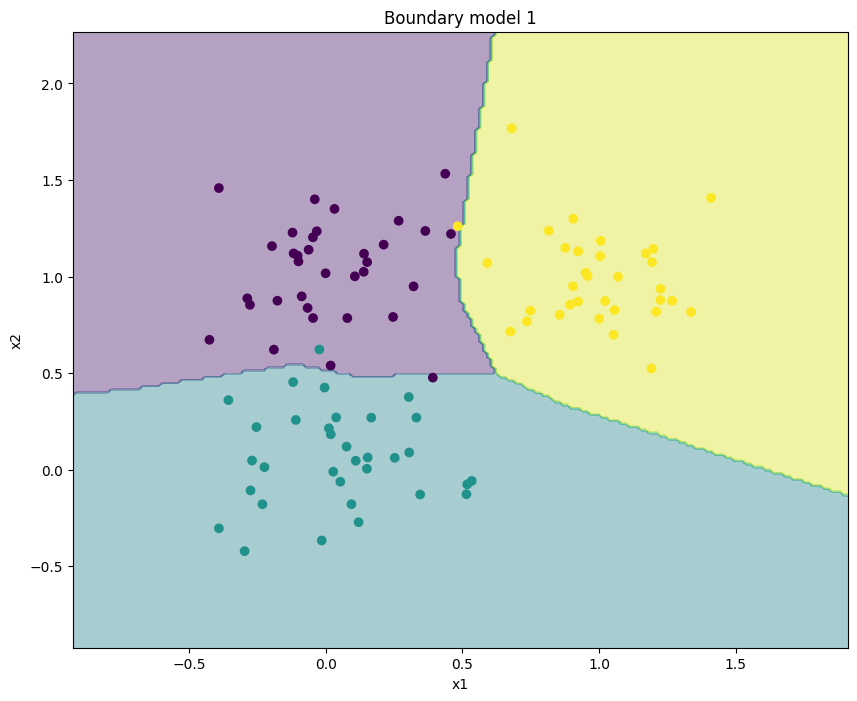

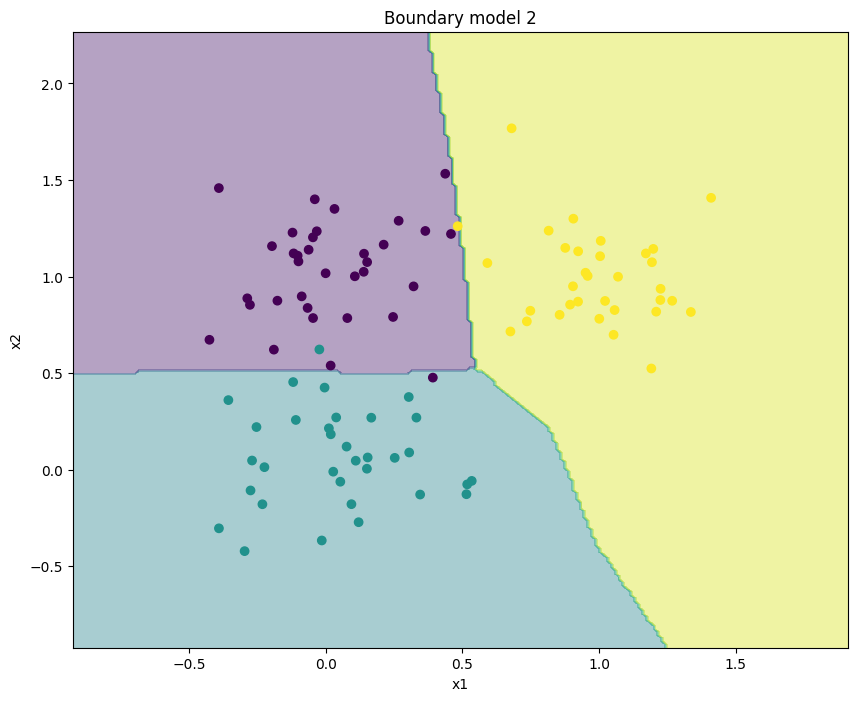

In [5]:
plot_decision_regions(model1, X_test, y_test, "Boundary model 1")
plot_decision_regions(model2, X_test, y_test, "Boundary model 2")

What can we say about the security of those models? The computation of security evaluations involve repeating attacks with increasing strength, hence it should approximate all the possible scenarios that can be envisioned once the models are deployed.

In [6]:
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
tracker = Sample2DTracker()

def security_evaluation(model, dataloader, epsilons, iterations=50, stepsize=1e-2):
    sec_eval_data = []
    for e in epsilons:
        tracker.reset()
        attack = PGD(
            perturbation_model=LpPerturbationModels.L1,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE,
            trackers=[tracker])

        adv_dataloader = attack(model, dataloader)
        # secmlt_plot_attack_path(model.model, dataloader.dataset[:][0], dataloader.dataset[:][1], dataloader.dataset[0][0], tracker.get(), e)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
    return sec_eval_data

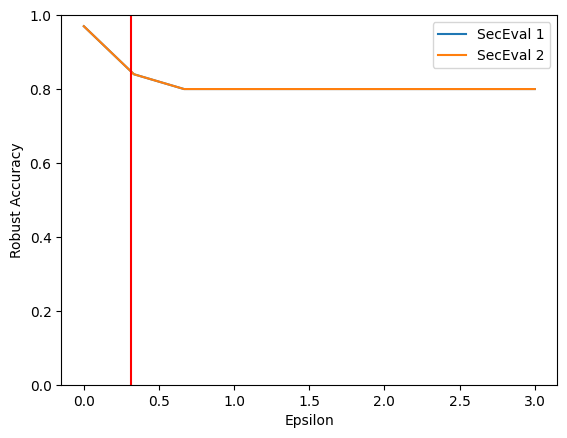

In [7]:
epsilons=np.linspace(0, 3, 10) # 10 numeri tra 0 e 3 tra un intervallo omogeneo
sec_eval_model1 = security_evaluation(secmlt_model, ts_dataloader, epsilons=epsilons)
sec_eval_model2 = security_evaluation(secmlt_model2, ts_dataloader, epsilons=epsilons)

plt.plot(epsilons, sec_eval_model1, label='SecEval 1')
plt.plot(epsilons, sec_eval_model2, label='SecEval 2')
plt.axvline(0.31578947, color='r')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [8]:
print(ts_dataloader.dataset[:][0])
print(ts_dataloader.dataset[:][1])
print(ts_dataloader.dataset.tensors[0])

tensor([[ 1.0035e+00,  1.1056e+00],
        [ 1.3865e-01,  1.0249e+00],
        [ 8.1532e-01,  1.2379e+00],
        [-4.7102e-02,  1.2033e+00],
        [-1.8994e-01,  6.2199e-01],
        [ 1.0059e+00,  1.1852e+00],
        [ 1.1274e-02,  2.1477e-01],
        [ 3.0349e-01,  3.7679e-01],
        [ 5.1448e-01, -1.2647e-01],
        [ 3.1789e-02,  1.3505e+00],
        [ 1.5040e-01,  5.5154e-03],
        [ 1.3983e-01,  1.1185e+00],
        [ 2.1176e-01,  1.1654e+00],
        [ 9.0564e-01,  1.2998e+00],
        [-1.7706e-01,  8.7535e-01],
        [ 9.0431e-01,  9.4997e-01],
        [ 4.8260e-01,  1.2610e+00],
        [-1.2176e-01,  1.2278e+00],
        [ 1.2248e+00,  9.3687e-01],
        [ 1.0954e-01,  4.7037e-02],
        [ 1.2671e+00,  8.7486e-01],
        [ 3.0509e-01,  8.9524e-02],
        [ 3.9157e-01,  4.7716e-01],
        [ 4.3694e-01,  1.5325e+00],
        [-6.6534e-02,  8.3777e-01],
        [ 1.0691e+00,  9.9930e-01],
        [ 1.0566e+00,  8.2693e-01],
        [-2.9706e-01, -4.210

## Exercise 1
TODO: review the exercise changing the iterations value and try to plot the path
1. What can you say about these evaluations? Are they ok? Is Model 2 more robust than Model 1, or viceversa? Try to change the parameters to better understand what is going on.
- If epsilon is less then 0.31 we can notice that the nn1 is a little more robust.
- Viceversa if epsilon is greater then 0.31 the nn2 is better.
- By the way both nn are not robust enough.
2. Repeat the security evaluations, but change the norm (L1 or LINF). Are those evaluations comparable?
- With LINF nn1 the robust is worst respect to L2 norm.
- With L1 norm the robust of both model improved.

Security evaluations are heuristics processes, which requires a lot of manual analysis.
Have a look at the code below: you should always use many iterations, or you need to debug your code to get through the solution.

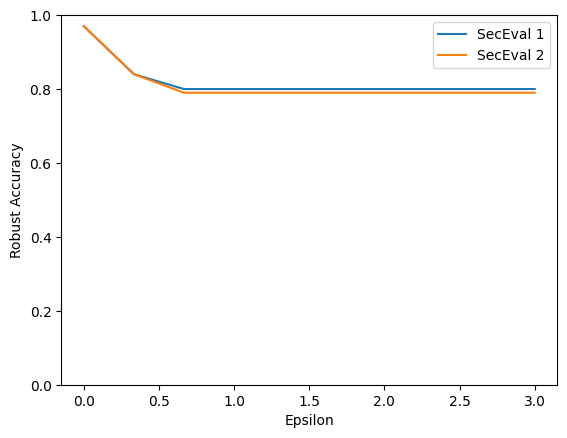

In [9]:
epsilons=np.linspace(0, 3, 10)
sec_eval_model1 = security_evaluation(secmlt_model, ts_dataloader, epsilons=epsilons, iterations=100, stepsize=1e-2)
sec_eval_model2 = security_evaluation(secmlt_model2, ts_dataloader, epsilons=epsilons, iterations=100, stepsize=1e-2)

plt.plot(epsilons, sec_eval_model1, label='SecEval 1')
plt.plot(epsilons, sec_eval_model2, label='SecEval 2')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Security Evaluations with Minimum Norm attacks

The security evaluations as we know works excellently for maximum confidence attacks, since we repeat the evaluation plenty of times with increased budget.
But what we can do for minimum norm attacks? These find, by design, always an adversarial example by reaching the boundary (given enough iterations of course).
Hence, we can run the attack only *once* and plot the variation of accuracy depending on the distance that has been found as evasive.

In [10]:
from secmlt.adv.evasion.fmn import FMN
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

def min_norm_security_evaluation(model, dataloader, iterations=300, stepsize=1e-1):
    fmn_attack = FMN(
        perturbation_model=LpPerturbationModels.L2,
        num_steps=iterations,
        step_size=stepsize,
        y_target=None,
        lb=-2,
        ub=2
    )
    adv_loader = fmn_attack(model, dataloader)
    # ensure that all attacks are successful
    print(f"Accuracy after attack:{Accuracy()(model, adv_loader) * 100:.2f}")
    distances = torch.norm(adv_loader.dataset.tensors[0] - dataloader.dataset.tensors[0], dim=-1, p=2)
    # we now count how many samples are evading the model with less then each budget, iteratively
    robust_accuracy = [(distances < d).sum().item() / adv_loader.dataset.tensors[0].shape[0] for d in distances]
    robust_accuracy.sort(reverse=True)
    distances = distances.tolist()
    distances.sort()
    return robust_accuracy, distances

Once we have computed the security evaluation with one single minimum norm attack, we can plot the achieved robust accuracy, and we can trust it if and only if it reached zero.

Accuracy after attack:0.00
Accuracy after attack:8.00


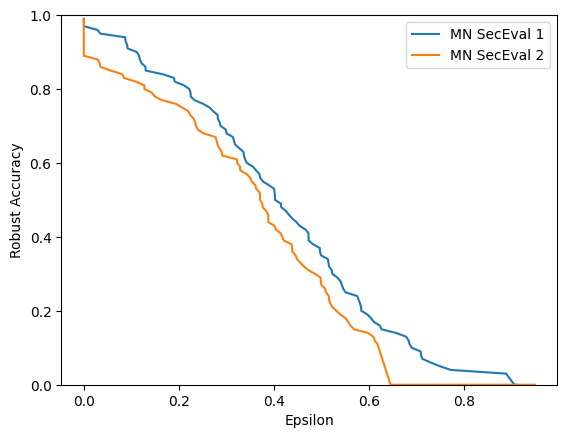

In [11]:
min_norm_seceval_1, dist1 = min_norm_security_evaluation(secmlt_model, ts_dataloader)
min_norm_seceval_2, dist2 = min_norm_security_evaluation(secmlt_model2, ts_dataloader)

plt.plot(dist1, min_norm_seceval_1, label='MN SecEval 1')
plt.plot(dist2, min_norm_seceval_2, label='MN SecEval 2')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

We can conclude that basically, both models behave in the same way from the point of view of robustness to L2 attacks.

## Exercise 2

1. Repeat the security evaluation using L1 or L-INF attacks with FMN and PGD.
- With L1: quite similar to the L2
- With L-INF: quite similar to the L2 but the Net with more params is little worst
* Compare the epsilon values of these security evaluations, what can you say about the values of epsilons? Are those inside the same range? Which one you think is better?

In [17]:
def min_norm_l1_security_evaluation(model, dataloader, iterations=500, stepsize=1e-1):
    fmn_attack = FMN(
        perturbation_model=LpPerturbationModels.L1,
        num_steps=iterations,
        step_size=stepsize,
        y_target=None,
        lb=-2,
        ub=2
    )
    adv_loader = fmn_attack(model, dataloader)
    # ensure that all attacks are successful
    print(f"Accuracy after attack:{Accuracy()(model, adv_loader) * 100:.2f}")
    distances = torch.norm(adv_loader.dataset.tensors[0] - dataloader.dataset.tensors[0], dim=-1, p=2)
    # we now count how many samples are evading the model with less then each budget, iteratively
    robust_accuracy = [(distances < d).sum().item() / adv_loader.dataset.tensors[0].shape[0] for d in distances]
    robust_accuracy.sort(reverse=True)
    distances = distances.tolist()
    distances.sort()
    return robust_accuracy, distances

In [18]:
def min_norm_linf_security_evaluation(model, dataloader, iterations=500, stepsize=1e-1):
    fmn_attack = FMN(
        perturbation_model=LpPerturbationModels.LINF,
        num_steps=iterations,
        step_size=stepsize,
        y_target=None,
        lb=-2,
        ub=2
    )
    adv_loader = fmn_attack(model, dataloader)
    # ensure that all attacks are successful
    print(f"Accuracy after attack:{Accuracy()(model, adv_loader) * 100:.2f}")
    distances = torch.norm(adv_loader.dataset.tensors[0] - dataloader.dataset.tensors[0], dim=-1, p=2)
    # we now count how many samples are evading the model with less then each budget, iteratively
    robust_accuracy = [(distances < d).sum().item() / adv_loader.dataset.tensors[0].shape[0] for d in distances]
    robust_accuracy.sort(reverse=True)
    distances = distances.tolist()
    distances.sort()
    return robust_accuracy, distances

# Min norm sec eval with L1

Accuracy after attack:0.00
Accuracy after attack:8.00


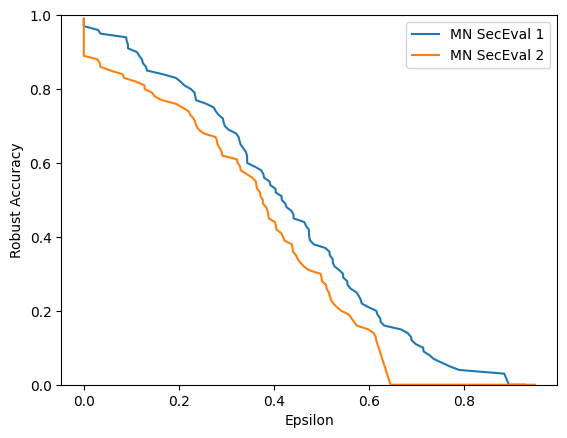

In [19]:
min_norm_seceval_1, dist1 = min_norm_l1_security_evaluation(secmlt_model, ts_dataloader)
min_norm_seceval_2, dist2 = min_norm_l1_security_evaluation(secmlt_model2, ts_dataloader)

plt.plot(dist1, min_norm_seceval_1, label='MN SecEval 1')
plt.plot(dist2, min_norm_seceval_2, label='MN SecEval 2')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Min norm sec eval with LINF

Accuracy after attack:0.00
Accuracy after attack:8.00


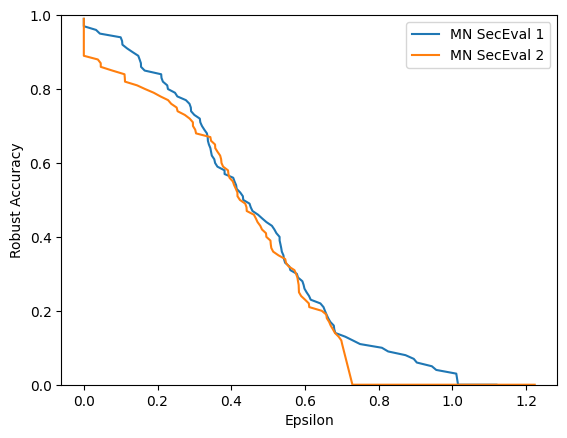

In [20]:
min_norm_seceval_1, dist1 = min_norm_linf_security_evaluation(secmlt_model, ts_dataloader)
min_norm_seceval_2, dist2 = min_norm_linf_security_evaluation(secmlt_model2, ts_dataloader)

plt.plot(dist1, min_norm_seceval_1, label='MN SecEval 1')
plt.plot(dist2, min_norm_seceval_2, label='MN SecEval 2')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()